## Hybrid Ice Stream Tidewater

Set up the tidewater side of the model, testing out remeshing to remove zero-thickness areas of ice.

Import firedrake and set initial conditions.

In [1]:
import firedrake
import icepack
import matplotlib.pyplot as plt
import numpy as np

Lx = 100e3
nx = 72

mesh1d = firedrake.IntervalMesh(nx, Lx)
mesh = firedrake.ExtrudedMesh(mesh1d, layers=1)

/home/sorenthompson/firedrake/src/ngsPETSc/ngsPETSc/eps.py:10: UserWarning: Import Warning: it was not possible to import SLEPc
  warnings.warn("Import Warning: it was not possible to import SLEPc")
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Set up function spaces for the scalars (Q) and vectors (V) for the 2D mesh.

In [2]:
Q = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="R", vdegree=0)
V = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="GL", vdegree=2)

Import a couple constant values from icepack.

In [3]:
from icepack.constants import(
    ice_density as rho_ice,           # ρ_I | 9.21e-19
    water_density as rho_water,       # ρ_W | 1.03e-18
    weertman_sliding_law as weertman, # m   | 3.0
    gravity as g,                     # g   | 9.77e15
)

Set up spatial coordinates and parameterize bed and surface geometry.

$\tau_D$ = driving stress

$$
\tau_D = -\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}
$$

where $g = $ gravity

$h_{in} = $ incoming height

$\frac{\delta s}{\delta x}$ = surface slope

In [4]:
from firedrake import max_value, min_value
from firedrake import conditional, eq, ne, le, ge, lt, gt

x, z = firedrake.SpatialCoordinate(mesh)

b_in, b_out = 100, -200
base_x = b_in - (b_in - b_out) * x/Lx
b = firedrake.interpolate(base_x, Q)

h_in, h_out = 600, 100
h0_x = h_in - (h_in - h_out) * x/Lx
h0 = firedrake.interpolate(h0_x, Q)

# s_in, s_out = 850, 0
# surface_x = s_in - (s_in - s_out) * x/Lx
# s0 = firedrake.interpolate(surface_x, Q)

# height_x = s0 - b
# h0 = firedrake.interpolate(height_x, Q) # Scalar function space

s0 = icepack.compute_surface(thickness = h0, bed = b)

# h_in = s_in - b_in
# surface_slope = (s_out - s_in) / Lx # δs_δx
surface_slope = ((b_out + h_out) - (b_in + h_in)) / Lx
tau_D = -rho_ice * g * h_in * surface_slope # driving stress

Check what the profile looks like.

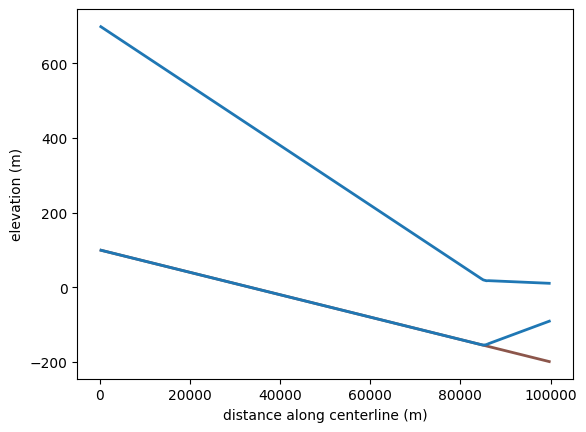

In [5]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes)
zb0 = firedrake.interpolate(s0-h0, Q)
firedrake.plot(icepack.depth_average(zb0), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(s0), edgecolor="tab:blue", axes = axes);

Estimate intial velocities, increasing exponentially towards the terminus.

$$
u_x = u_{in} + (u_{out} - u_{in}) * \left(\frac{x}{Lx}\right)^2
$$

Just an interpolation between $u_{in}$ and $u_{out}$ using a square.

In [6]:
u_in, u_out = 20, 2400
velocity_x = u_in + (u_out - u_in) * (x / Lx)**2
u0 = firedrake.interpolate(velocity_x,V) # Vector function space

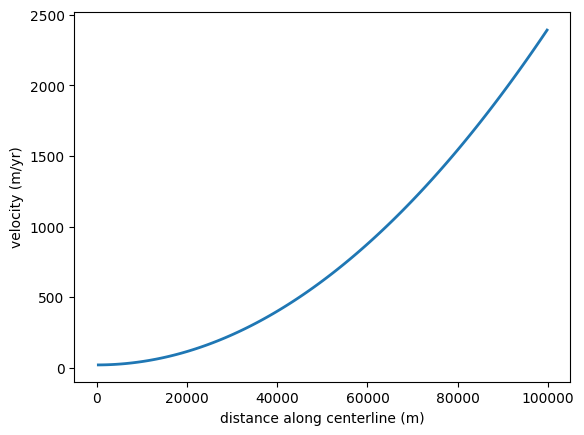

In [7]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("velocity (m/yr)")
firedrake.plot(icepack.depth_average(u0), edgecolor="tab:blue", axes=axes);

Set up icepack values.

water pressure = water density * gravity * amount of ice under the water line (elevation = 0)
ice pressure = ice density * gravity * ice height
phi = ramping function for friction.
- If no water pressure, then phi = 1.
- If ice pressure equals water pressure, then phi = 0.

$C$ = Friction Coeff

$$
C = (0.95 - 0.05 \frac{x}{Lx}) \times \frac{\tau_D}{u_{in}^{1/3}}
$$

where $\tau_D =$ driving stress
and $u_{in} = $ incoming velocity at source

Expanding the driving stress, this is

$$
C = -\left(0.95 - 0.05 \frac{x}{Lx}\right) \times \frac{\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}}{u_{in}^{1/3}}
$$

$C$ decreases slightly along length, then is a ratio of driving stress and incoming velocity

In [8]:
Temperature = firedrake.Constant(255.0) # -18 deg C
A = icepack.rate_factor(Temperature) # flow rate factor

C = firedrake.interpolate((0.95 - 0.05 * x/Lx) * tau_D / u_in ** (1/weertman), Q) # Friction Coeff

$\phi$ = relative pressure at that point

$p_w =$ upward pressure of submerged ice

$p_I = $ downward pressure of unsubmerged ice

In [9]:
p_water = rho_water * g * max_value(0, h0 - s0) # Prevents negative thickness
p_ice = rho_ice * g * h0
phi = 1 - p_water / p_ice # Are there issues if phi = 0?

#### Weertman friction
The law defines the driving stress as

$$
\tau_b = -C|u|^{\frac{1}{m}-1}u
$$

And the energy dissipation is

$$
E(u) = \int \frac{m}{m + 1}C|u|^{\frac{1}{m} + 1}dx.
$$

Weertman is already implemented in Icepack in the `icepack.models.hybrid.bed_friction(velocity = u, friction = C*phi)` function below.

#### Schoof friction approximation

This is implemented in the Synthetic Flowline Ice Stream tutorial as an approximation of the Schoof sliding law. When the velocity is small, energy dissipation acts relative to $|u|^1$, and when it is large, it acts relative to $|u|^{\frac{1}{m}+1}$. The factor $-U_0$ means that there is no flow when there is no energy dissipation.

$$
E(u) = \int \tau_0 \left( \left( U_0^{\frac{1}{m}+1}+|u|^{\frac{1}{m}+1}\right)^{\frac{m}{m+1}} - U_0 \right) dx
$$

In the implementation, $\tau_0$ is

$$
\tau_0 = C \left( U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}}\right)^{\frac{1}{m+1}}
$$

$\phi$ is implemented the same as above, where the amount of water displaced is the height of ice submerged $h_{sub} = h-s$

$$
\phi = 1 - \frac{\rho_{water}}{\rho_{ice}} \frac{(h_{sub})}{h_{supra}}
$$

Finally, friction is calculated as

$$
\tau_0 \times \phi \times \left(\left(U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}} \right)^{\frac{1}{m+1}} - U_0 \right)
$$


In [10]:
import icepack.models.hybrid

## Weertman friction
def weertman_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = 1 - p_water/p_ice
    
    return icepack.models.hybrid.bed_friction(
        velocity = u,
        friction = C * phi,
    )

from firedrake import sqrt, inner

def schoof_approx_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    U_0 = firedrake.Constant(50)
    U = sqrt(inner(u,u)) # Supposed to be u0, does this work?
    tau_0 = firedrake.interpolate(
        C*( U_0**(1/weertman+1) + U**(1/weertman+1) )**(1/(weertman+1)), Q
    ) # Including Q is an issue here, can we reference the current Q through one of the functions?
    
    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = 1 - p_water/p_ice

    U = sqrt(inner(u, u))
    return tau_0 * phi * (
        (U_0**(1/weertman+1) + U**(1/weertman+1))**(weertman/(weertman+1))-U_0
    )

Set up hybrid model solver with custom friction function and initialize the velocity field.

In [11]:
# model = icepack.models.HybridModel(friction = schoof_approx_friction)
model = icepack.models.HybridModel(friction = weertman_friction)
opts = {
    "dirichlet_ids": [1],
    #"diagnostic_solver_type": "petsc",
    #"diagnostic_solver_parameters": {"snes_type": "newtontr"},
}

solver = icepack.solvers.FlowSolver(model, **opts)

u0 = solver.diagnostic_solve(
    velocity = u0,
    thickness = h0,
    surface = s0,
    fluidity = A,
    friction = C,
)

Plot new initial velocities.

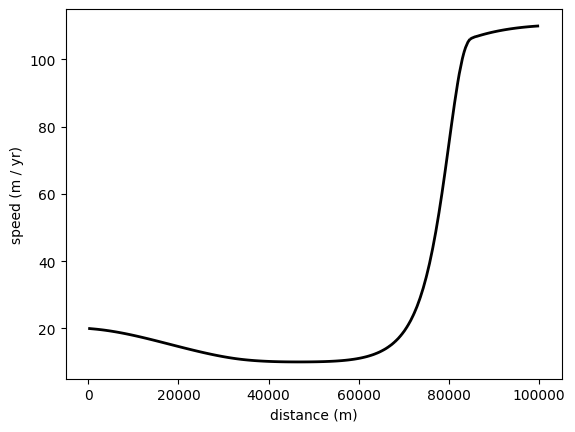

In [12]:
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("speed (m / yr)")
firedrake.plot(icepack.depth_average(u0), axes=axes);

### Run the actual model

In [13]:
h_min = 10 # base height past the terminus/"empty" portion of the glacier
h_calving = 50 # the height the glacier calves at.
cal_step = h_calving - h_min

In [14]:
from scipy.interpolate import interp1d
import xarray

def shrink_function(func_src, nx, Lx_src, Lx_dest, funcspace_dest):
    # Pull out list of values from func_src
    f_data_src = func_src.dat.data
    
    # Initialize linspace lists with lengths Lx_src and Lx_dest
    f_data_len = len(f_data_src)
    f_ls_src = np.linspace(0, Lx_src, f_data_len, endpoint=True)
    f_ls_dest= np.linspace(0, Lx_dest, f_data_len, endpoint=True)
    
    # Interpolate f_data_src from f_ls_src to f_ls_dest
    f_interpolator = interp1d(f_ls_src, f_data_src, kind='linear', fill_value='extrapolate')
    f_data_dest = f_interpolator(f_ls_dest)
    
    # Convert f_data_dest into a firedrake function on destination function space funcspace_dest
    temp_dest = xarray.DataArray(f_data_dest, [f_ls_dest], 'x')
    func_dest = icepack.interpolate(temp_dest, funcspace_dest)
    
    return func_dest

In [15]:
def shrink_model(nx, Lx_src, Lx_dest, h_src, u_src, a_src, h0_src, b_src, s_src, C_src):
    # Initialize mesh and mesh spaces
    mesh1d_dest = firedrake.IntervalMesh(nx, Lx_dest)
    mesh_dest = firedrake.ExtrudedMesh(mesh1d_dest, layers=1)
    Q_dest = firedrake.FunctionSpace(mesh_dest, "CG", 2, vfamily="R", vdegree=0)
    V_dest = firedrake.FunctionSpace(mesh_dest, "CG", 2, vfamily="GL", vdegree=0)
    
    # Remesh all functions
    h_dest =  shrink_function(h_src,  nx, Lx_src, Lx_dest, Q_dest)
    u_dest =  shrink_function(u_src,  nx, Lx_src, Lx_dest, V_dest)
    a_dest =  shrink_function(a_src,  nx, Lx_src, Lx_dest, Q_dest)
    h0_dest = shrink_function(h0_src, nx, Lx_src, Lx_dest, Q_dest)
    b_dest =  shrink_function(b_src,  nx, Lx_src, Lx_dest, Q_dest)
    s_dest =  shrink_function(s_src,  nx, Lx_src, Lx_dest, Q_dest)
    C_dest =  shrink_function(C_src,  nx, Lx_src, Lx_dest, Q_dest)
    
    return Q_dest, V_dest, h_dest, u_dest, a_dest, h0_dest, b_dest, s_dest, C_dest

In [42]:
def find_endpoint(src_lx, src_nx, src_h, h_min):
    # print(src_h.dat.data)
    h_dat = src_h.dat.data
    x_dat = np.linspace(0, src_lx, len(src_h.dat.data), endpoint=True)
    endpoint_interpolator = interp1d(h_dat, x_dat, fill_value='extrapolate')
    L_new = endpoint_interpolator(h_min)
    return L_new

def find_endpoint_2(src_lx, src_nx, src_h, h_min):
    for i in range(0, len(src_h.dat.data)):
        if src_h.dat.data[i] <= h_min:
            delta_h = (src_h.dat.data[i-1] - src_h.dat.data[i])
            delta_l = src_lx/int(len(src_h.dat.data))
            small_l = (h_min-src_h.dat.data[i]) * delta_l / delta_h
            return src_lx * (i-1) / len(src_h.dat.data) + small_l
    return src_lx

def find_endpoint_haf(src_lx, src_nx, src_h, src_s, src_Q):
    zb_end = firedrake.interpolate(src_s-src_h, src_Q)
    # zb_end = src_b
    float_h = firedrake.interpolate(-rho_water/rho_ice*zb_end, src_Q)
    h_above_f = firedrake.interpolate(src_h - float_h, src_Q)

    # fig, axes = plt.subplots()
    # axes.set_xlabel("distance (m)")
    # axes.set_ylabel("HAF (m)")
    # firedrake.plot(icepack.depth_average(h_above_f), axes=axes);

    haf_dat = h_above_f.dat.data
    x_dat = np.linspace(0, src_lx, len(src_h.dat.data), endpoint=True)
    haf_interpolator = interp1d(haf_dat, x_dat, fill_value='extrapolate')
    L_new = haf_interpolator(1)
    return L_new
    
    # zb = firedrake.interpolate(model_s-model_h, model_Q)

In [46]:
import tqdm

num_years = 100
timesteps_per_year = 2

dt = 1.0/timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a = firedrake.interpolate(1.7 - 4.7 * x / Lx, Q)
h = h0.copy(deepcopy = True)
u = u0.copy(deepcopy = True)
s = icepack.compute_surface(thickness=h, bed=b)

# Copy over values to initialize versions that can be modified in the model loop

model_nx = nx
model_Lx = Lx

# Use shrink_model function to make copies of functions and function spaces
model_Q, model_V, model_h, model_u, model_a, model_h0, model_b, model_s, model_C = shrink_model(
    nx, Lx, Lx, h, u, a, h0, b, s, C)

# Initialize a new solver
loop_model = icepack.models.HybridModel(friction = weertman_friction)
model_solver = icepack.solvers.FlowSolver(loop_model, **opts)

Lx_list_1 = np.zeros(num_timesteps) * np.nan
Lx_list_2 = np.zeros(num_timesteps) * np.nan
h_min_list = np.zeros(num_timesteps) * np.nan
u_min_list = np.zeros(num_timesteps) * np.nan

# Run the model loop
for step in tqdm.trange(num_timesteps):
    prev_h = model_h.copy(deepcopy = True)
    prev_s = model_s.copy(deepcopy = True)
    prev_b = model_b.copy(deepcopy = True)
    prev_u = model_u.copy(deepcopy = True)
    prev_Q = model_Q
    
    
    model_h = model_solver.prognostic_solve(
        dt,
        thickness = model_h,
        velocity = model_u,
        accumulation = model_a,
        thickness_inflow = model_h0,
    )

    mid_h_1 = model_h.copy(deepcopy = True)

    model_s = icepack.compute_surface(thickness = model_h, bed = model_b)

    # temp_Lx= find_endpoint(model_Lx, nx, model_h, h_calving) # TODO: loop crashes when using this version of the find_endpoint function 
    temp_Lx= find_endpoint_haf(model_Lx, nx, model_h, model_s, model_Q)
    # def find_endpoint_haf(src_lx, src_nx, src_h, src_s, src_Q):
    temp_Lx_2 = find_endpoint_2(model_Lx, nx, model_h, h_calving)
    
    Lx_list_1[step] = temp_Lx
    Lx_list_2[step] = temp_Lx_2
    h_min_list[step] = model_h.dat.data_ro.min()
    u_min_list[step] = model_u.dat.data.min()
    
    if (temp_Lx < model_Lx):
        print(model_h.dat.data)
        # print("temp Lx = " + str(temp_Lx))
        # print("endpoint_height = " + str(model_h.at(temp_Lx,0)) + ", " + str(model_h.at(temp_Lx,1)))
        model_Q, model_V, model_h, model_u, model_a, model_h0, model_b, model_s, model_C = shrink_model(
            model_nx, model_Lx, temp_Lx, model_h, model_u, model_a, model_h0, model_b, model_s, model_C)
        print(model_h.dat.data)
        model_Lx = temp_Lx
        
        loop_model = icepack.models.HybridModel(friction = weertman_friction)
        model_solver = icepack.solvers.FlowSolver(loop_model, **opts)

    mid_h_2 = model_h.copy(deepcopy = True)
    
    model_u = model_solver.diagnostic_solve(
        velocity = model_u,
        thickness = model_h,
        surface = model_s,
        fluidity = A,
        friction = model_C,
    )

print("Done!")

  0%|                                                          | 0/200 [00:00<?, ?it/s]

[600.92814048 596.89232352 594.15810191 590.45584679 587.02166231
 583.5026923  580.02600207 576.53540855 573.051467   569.56493538
 566.07940882 562.59308115 559.10686321 555.62011396 552.13333838
 548.64607123 545.1587639  541.67097999 538.18316163 534.69488633
 531.20658514 527.71785252 524.22910257 520.73994962 517.25078746
 513.76125058 510.27171215 506.78182466 503.29194285 499.80173316
 496.31153609 492.8210265  489.33053632 485.83974252 482.34897488
 478.85790607 475.36687027 471.87553022 468.38423016 464.89261954
 461.401056   457.90917648 454.41735103 450.92521174 447.43313285
 443.94075974 440.44844715 436.9558928  433.46330434 429.97082556
 426.47854361 422.98677002 419.49508518 416.00383509 412.51264393
 409.0218152  405.5310352  402.04056447 398.55013637 395.0599784
 391.56985755 388.07997487 384.59012285 381.1004841  377.6108701
 374.12146434 370.63209765 367.14291002 363.65376432 360.16458577
 356.67541661 353.18604494 349.69678199 346.20731625 342.71780083
 339.2280413

  0%|▎                                                 | 1/200 [00:00<00:59,  3.35it/s]

[598.01365002 601.76119597 595.29071481 591.87089749 588.54049427
 585.19663891 581.86047502 578.52697467 575.19254024 571.85878656
 568.52434929 565.18954402 561.8543148  558.51843121 555.1821723
 551.84521938 548.50787864 545.16988206 541.83147768 538.49248402
 535.15306824 531.81313989 528.47278277 525.13195954 521.79076941
 518.44912452 515.10718013 511.76478746 508.42215648 505.07908165
 501.73582314 498.39212023 495.04828245 491.70399198 488.3596111
 485.01475928 481.66985909 478.32445834 474.97905105 471.63310256
 468.28719089 464.94068983 461.59427113 458.24721723 454.90026915
 451.55270411 448.20522795 444.85721607 441.50925426 438.1609183
 434.81249196 431.46424854 428.11633354 424.76934976 421.42271717
 418.07682833 414.7312525  411.38628856 408.04161297 404.69746848
 401.35359436 398.0101978  394.66705949 391.32434362 387.98187597
 384.63974748 381.29783302 377.95615011 374.61464756 371.27330842
 367.9321095  364.59102395 361.24993599 357.90883997 354.56765045
 351.22637137

  1%|▌                                                 | 2/200 [00:00<01:05,  3.04it/s]

[602.31199776 598.59335708 597.38987495 593.69816228 590.63715025
 587.59122311 584.5464081  581.5049689  578.46513911 575.42446037
 572.38421503 569.34308373 566.301561   563.25931205 560.21649405
 557.17289549 554.12876866 551.08377194 548.03831887 544.99195543
 541.94518921 538.8975269  535.84948507 532.80057374 529.75128677
 526.70123625 523.6508493  520.59975461 517.54834547 514.49630333
 511.44394373 508.39104114 505.33779631 502.28410433 499.23002168
 496.17554165 493.12073846 490.0655158  487.01003704 483.95408737
 480.89796641 477.84128972 474.78455036 471.72713311 468.66978211
 465.61162184 462.55355592 459.49475922 456.43594461 453.37654546
 450.31699847 447.25703063 444.19682688 441.1363544  438.07564757
 435.01471327 431.95397016 428.89389794 425.83464301 422.77625453
 419.71842042 416.66141934 413.60482242 410.54901828 407.49352708
 404.4388046  401.3843425  398.33064315 395.27718981 392.22438746
 389.17185109 386.11984785 383.06808981 380.0167168  376.96553248
 373.91461

  2%|▊                                                 | 3/200 [00:00<01:05,  3.01it/s]

[599.60915802 603.04291332 598.27549479 594.83051812 591.76186706
 588.78184491 585.7887988  582.8037792  579.81804485 576.83256896
 573.84682537 570.86040191 567.87336905 564.88543331 561.8968431
 558.90720077 555.91692118 552.92551753 549.93348606 546.94033136
 543.94655246 540.95169818 537.95622322 534.95972792 531.96261156
 528.96456196 525.96594826 522.9664826  519.96648113 516.96570601
 513.96442851 510.96244026 507.95999237 504.95687401 501.9533457
 498.9491466  495.94459094 492.93942266 489.93389523 486.92781143
 483.9213368  480.91437825 477.90695944 474.89915702 471.89077705
 468.88214683 465.87279364 462.86324041 459.85301961 456.84248231
 453.83144955 450.81996348 447.80814519 444.79581672 441.78328198
 438.77031269 435.75713603 432.74404587 429.73162905 426.7204366
 423.7101349  420.70086738 417.69237076 414.68476727 411.6778395
 408.67172555 405.66621631 402.66148836 399.657315   396.65392763
 393.65100708 390.64883624 387.64706842 384.6459524  381.64514939
 378.64482599 

  2%|█                                                 | 4/200 [00:01<01:09,  2.82it/s]

[603.94137772 600.07342284 599.18481588 595.7298875  592.65076216
 589.66467788 586.66624342 583.67546466 580.68413918 577.69293668
 574.70143979 571.70908288 568.71605965 565.72186485 562.72695438
 559.73065989 556.73366524 553.73517549 550.73599598 547.73530094
 544.7339237  541.73107137 538.72754664 535.72260626 532.71700076
 529.71007567 526.7025485  523.69380003 520.68448545 517.67404593
 514.66308139 511.65107369 508.63859028 505.62512306 502.6112347
 499.59638219 496.58116279 493.56505029 490.54857597 487.53127064
 484.51358124 481.49513169 478.47624189 475.45668151 472.43658346
 469.41592616 466.39461432 463.3727696  460.35033462 457.32725589
 454.30374436 451.27947831 448.25492304 445.22959442 442.20408343
 439.17793679 436.15157921 433.12522716 430.09961043 427.07562672
 424.05263724 421.03108301 418.01037519 414.99091984 411.97220306
 408.95463134 405.93772039 402.92190569 399.90669813 396.89258089
 393.87898962 390.86643608 387.85434694 384.84316296 381.83234941
 378.822200

  2%|█▎                                                | 5/200 [00:01<01:06,  2.95it/s]

[601.02413117 604.56366501 599.99258436 596.63740339 593.52147014
 590.54526045 587.53728581 584.54343734 581.545987   578.54970141
 575.55257853 572.55466912 569.55595204 566.55588766 563.55502805
 560.55250806 557.54921443 554.54409363 551.53820952 548.53044484
 545.52192629 542.51155088 539.5004359  536.48752047 533.47387908
 530.45853689 527.44253688 524.42494733 521.40674312 518.38706121
 515.36681301 512.34518651 509.32304943 506.2996121  503.27572363
 500.25057489 497.2250306  494.19831081 491.17120812 488.14299982
 485.1143953  482.08475711 479.05467873 476.02364895 472.99209934
 469.9596923  466.92667322 463.89280518 460.85839457 457.8230324
 454.78727015 451.75047007 448.7133957  445.67529797 442.6370174
 439.59790339 436.55856082 433.51911768 430.48044276 427.44375381
 424.40819628 421.37443859 418.34163577 415.31041206 412.28002023
 409.25107446 406.22287463 403.19605744 400.16992856 397.14516777
 394.12101977 391.09817676 388.07588613 385.05474358 382.03405377
 379.0142150

  3%|█▌                                                | 6/200 [00:02<01:14,  2.60it/s]

[605.47047098 601.38706052 600.88097256 597.53260228 594.40254174
 591.42219302 588.40867073 585.40947834 582.40670101 579.40511568
 576.40267303 573.39938906 570.39524448 567.38959236 564.38307752
 561.37465972 558.36539131 555.35399478 552.34175291 549.32729088
 546.31199198 543.29447446 540.27613671 537.25562895 534.23431926
 531.21093913 528.18682907 525.16076967 522.1340299  519.10546591
 516.07627667 513.04537882 510.01391745 506.98084352 503.94727024
 500.91214437 497.87657649 494.83955464 491.80211089 488.76329202
 485.72404641 482.68350054 479.64249515 476.60026713 473.55751587
 470.51362237 467.46913453 464.42349994 461.37734261 458.32994588
 455.28215404 452.23305892 449.18367866 446.13303799 443.08219171
 440.03031755 436.9781843  433.9258212  430.87422963 427.82492135
 424.77690912 421.73102991 418.68624222 415.64333242 412.60137379
 409.56113638 406.52175483 403.48401792 400.44707477 397.41175483
 394.37715789 391.34411555 388.31173628 385.28073981 382.25030038
 379.22090

  4%|█▊                                                | 7/200 [00:02<01:09,  2.78it/s]

[602.34710126 605.99289099 601.65979011 598.43786482 595.26554379
 592.29797164 589.27441976 586.27263155 583.26386329 580.25755207
 577.24982117 574.24146196 571.23210365 568.22117916 565.20930879
 562.19535717 559.18047043 556.16320271 553.14499869 550.12427126
 547.1026125  544.07839992 541.05327268 538.02562428 534.99708242
 531.96611255 528.93432376 525.90023282 522.86537806 519.82835597
 516.79063133 513.75086882 510.71047124 507.66814848 504.62525952
 501.58052469 498.53528322 495.48830848 492.44085461 489.39175647
 486.34218257 483.29104412 480.23940757 477.18628227 474.1326094
 471.07751852 468.021827   464.96470477 461.90705326 458.84788995
 455.78831064 452.72717629 449.66572209 446.60277982 443.53958863
 440.47517577 437.41046128 434.34536412 431.28101157 428.21918172
 425.15883329 422.10092214 419.04426283 415.98975514 412.93633968
 409.88489764 406.83444205 403.7858716  400.73822059 397.69242804
 394.64748814 391.60433693 388.56197854 385.52123057 382.48116317
 379.442329

  4%|██                                                | 8/200 [00:02<01:10,  2.72it/s]

[606.90744401 602.61652359 602.52763031 599.33002357 596.14086609
 593.17029595 590.1411629  587.13413053 584.12019575 581.10882666
 578.09606993 575.08274935 572.06839432 569.05243101 566.0354559
 563.01625993 559.99604422 556.9732314  553.94938564 550.92274428
 547.89506813 544.86452824 541.8329677  538.7985549  535.76314351
 532.7249623  529.68585798 526.64411072 523.60149988 520.55638777
 517.5104787  514.46220954 511.41321619 508.36199061 505.31011423
 502.25610329 499.2015037  496.14489568 493.08773385 490.02866332
 486.96905026 483.90761433 480.84562328 477.78188541 474.71755573
 471.65154341 468.58490154 465.51655997 462.44765812 459.37698781
 456.305857   453.23293292 450.15963269 447.08462593 444.00930833
 440.93257615 437.85548871 434.77784451 431.70088745 428.62663559
 425.55406444 422.4842101  419.41578728 416.34976897 413.2850018
 410.22244105 407.16101427 404.10169509 401.0434376  397.98725718
 394.93207492 391.87890243 388.82666827 385.77626648 382.72668538
 379.6785374

  4%|██▎                                               | 9/200 [00:03<01:06,  2.89it/s]

[603.58576857 607.33733353 603.27813572 600.23383699 596.99817532
 594.0423797  591.00287433 587.99338641 584.97348483 581.95755222
 578.93969498 575.9216183  572.90238476 569.88160884 566.85974248
 563.83558658 560.81032242 557.78230038 554.75314329 551.72096219
 548.68763451 545.65116695 542.61356172 539.57279819 536.53091766
 533.48594348 530.43992703 527.39093884 524.34097117 521.28817574
 518.23447193 515.17808997 512.12087721 509.06112706 506.00062391
 502.9376978  499.87408385 496.80818599 493.74164243 490.67292582
 487.60358258 484.5321595  481.4601064  478.38605185 475.31134219
 472.23469182 469.15736165 466.07807296 462.99817049 459.91625377
 456.83381069 453.74934515 450.66442783 447.57759089 444.49036461
 441.40152894 438.31227426 435.22226742 432.13285987 429.04628244
 425.96159167 422.87987426 419.79978303 416.72233082 413.64630256
 410.57269704 407.50038611 404.4303898  401.36161023 398.29511223
 395.22977008 392.16664771 389.10462162 386.04464488 382.98564279
 379.92827

  5%|██▍                                              | 10/200 [00:03<01:08,  2.79it/s]

[608.25899638 603.76825107 604.12547747 601.12369463 597.86965984
 594.91115597 591.86613968 588.85117345 585.82612876 582.80516853
 579.78240583 576.75960045 573.73563243 570.71020465 567.68363037
 564.65474037 561.6246575  558.59169728 555.5574979  552.52008177
 549.48140165 546.43933517 543.39600544 540.34923542 537.30121904
 534.24980439 531.19721547 528.14134086 525.08435658 522.02422941
 518.96306713 515.89891722 512.83381391 509.7658745  506.69706359
 503.62554614 500.55322564 497.47834958 494.40271981 491.32465644
 488.24586603 485.16474328 482.08289885 478.99880424 475.91397342
 472.82695209 469.73918097 466.64920352 463.55853831 460.46562409
 457.3720985  454.27633021 451.18001724 448.08157691 444.98265388
 441.88192516 438.78070438 435.6785171  432.57681109 429.4780046
 426.38129073 423.2877868  420.19611495 417.10730161 414.02009569
 410.9355152  407.85239998 404.77179369 401.69256902 398.61581884
 395.54039152 392.46738481 389.39564212 386.32616166 383.2578213
 380.1913310

  6%|██▋                                              | 11/200 [00:03<01:04,  2.94it/s]

[604.7464003  608.60263844 604.84798766 602.02656533 598.72327169
 595.78062403 592.72504374 589.70744419 586.67634128 583.65078838
 580.62295767 577.5955517  574.56688804 571.53695981 568.50581934
 565.47241282 562.43772892 559.40010947 556.3611453  553.31882186
 550.27511241 547.22781035 544.17911178 541.12672206 538.07294635
 535.01549114 531.95671729 528.89436049 525.83074988 522.76369258
 519.69545834 516.62393409 513.55131806 510.47557115 507.39881816
 504.31907661 501.23840096 498.1548983  495.07051801 491.98344345
 488.89552546 485.80502303 482.71369097 479.61986179 476.52519819
 473.42809837 470.33016013 467.22977436 464.12860795 461.02496449
 457.92060719 454.81379207 451.70632363 448.59652247 445.48613117
 442.37373545 439.26076248 436.14659844 433.03277084 429.92184577
 426.81321363 423.70800797 420.60484826 417.50475284 414.40645622
 411.31097544 408.21713804 405.12599259 402.03640091 398.94946636
 395.86402863 392.781204   389.69981873 386.62090431 383.54330501
 380.46777

  6%|██▉                                              | 12/200 [00:04<01:04,  2.91it/s]

[609.53070938 604.84762798 605.67469468 602.91460847 599.59293308
 596.64707928 593.5862105  590.56262555 587.52629947 584.49558076
 581.46282523 578.43077617 575.39750299 572.36317644 569.32759973
 566.28985208 563.25075078 560.20870099 557.16520298 554.11824312
 551.06977344 548.01753876 544.96376929 541.90608577 538.8468688
 535.7837138  532.71908577 529.6505953  526.5806951  523.5070581
 520.43208918 517.35353821 514.27374298 511.19052966 508.10616114
 505.01852732 501.92981385 498.83800575 495.74518138 492.64940528
 489.55265451 486.45307047 483.3525337  480.24925696 477.14503176
 474.03813032 470.93028476 467.81975795 464.70834057 461.59422514
 458.47927783 455.36166292 452.24327192 449.12234573 446.00070862
 442.87686799 439.75234989 436.62641728 433.50065457 430.37772275
 427.25727217 424.14044619 421.02588503 417.91458276 414.80527616
 411.69896586 408.59448221 405.49286426 402.3929773  399.29592165
 396.20054158 393.10796011 390.01699899 386.92871347 383.8419258
 380.75742645

  6%|███▏                                             | 13/200 [00:04<01:01,  3.02it/s]

[605.83432348 609.79357508 606.36927615 603.81665094 600.44472778
 597.51507928 594.44363931 591.41698734 588.37440991 585.33890235
 582.30096906 579.26432397 576.22639586 573.1877406  570.14779051
 567.10584357 564.06247105 561.01620291 557.96838609 554.91706045
 551.86410092 548.80724987 545.74872218 542.68609415 539.62177871
 536.55329507 533.48317503 530.4089341  527.33311659 524.25328706
 521.1719582  518.08676514 515.00016189 511.90985928 508.81823832
 505.72307809 502.62667868 499.52691773 496.42598767 493.32184809
 490.21658832 487.10824595 483.99881326 480.88639792 477.77290505
 474.65649764 471.53902445 468.41863954 465.29723857 462.17292153
 459.04764051 455.9194838  452.79041551 449.65860948 446.52595961
 443.39090453 440.2550578  437.11757216 433.98007055 430.84525637
 427.71309176 424.58473043 421.45885464 418.33642163 415.21618441
 412.09911465 408.98405788 405.87203205 402.76191746 399.65480062
 396.54954105 393.44725898 390.34678208 387.24918137 384.15326719
 381.05986

  7%|███▍                                             | 14/200 [00:04<01:02,  2.97it/s]

[610.72739342 605.85935165 607.17497506 604.70280077 601.3141677
 598.38030835 595.30397697 592.2706219  589.2226294  586.18164697
 583.13861457 580.09724823 577.05467889 574.01172247 570.96745937
 567.92142045 564.8738968  561.82357855 558.77161775 555.71614455
 552.65891608 549.59770701 546.53467871 543.46739514 540.39826639
 537.32476503 534.24945756 531.16979115 528.08837282 525.00268309
 521.91531645 518.82381533 515.73072671 512.63366598 509.53511164
 506.43274978 503.32897683 500.22157922 497.11284688 494.00064984
 490.88717412 487.77036857 484.65232192 481.53105227 478.40856239
 475.28292287 472.15608159 469.02610226 465.89496759 462.76070229
 459.62532855 456.48687314 453.34735944 450.20490582 447.06146461
 443.9154146  440.76844594 437.61961341 434.47056187 431.32398856
 428.18020652 425.04038738 421.90327346 418.76977734 415.63867838
 412.51091044 409.38534309 406.26296489 403.14267949 400.02555182
 396.91046436 393.79852764 390.68858318 387.58171156 384.47671946
 381.374466

  8%|███▋                                             | 15/200 [00:05<01:01,  2.98it/s]

[606.85416896 610.91434804 607.84161667 605.60355195 602.16541439
 599.2477278  596.16106045 593.12405931 590.06953471 587.02339766
 583.97492096 580.92879131 577.88144287 574.83416189 571.78555837
 568.73547993 565.68386629 562.6296277  559.57366053 556.51423713
 553.45294171 550.38762727 547.32035213 544.24870833 541.17505948
 538.09686658 535.01669302 531.93194755 528.84526766 525.75407527
 522.66101934 519.56357122 516.46434789 513.36088753 510.25574702
 507.14653471 504.03572779 500.92103434 497.80482855 494.68490238
 491.56352682 488.43857291 485.31221467 482.18239176 479.05119317
 475.9166093  472.7806744  469.64137533 466.50076916 463.35681746
 460.21160179 457.06309715 453.91337753 450.76051329 447.60650795
 444.4496862  441.29180695 438.13183636 434.9714285  431.8132277
 428.6579276  425.50672851 422.35845041 419.2139559  416.07205941
 412.93364998 409.79762842 406.66494735 403.53454043 400.40744498
 397.28257251 394.16101839 391.04164444 387.92553565 384.8115022
 381.7004353

  8%|███▉                                             | 16/200 [00:05<01:00,  3.04it/s]

[611.8533063  606.80760692 608.62583506 606.48720169 603.03554601
 600.11246228 597.02154981 593.97709003 590.91690507 587.86482663
 584.81092167 581.75981404 578.70762064 575.65595791 572.60299439
 569.54890334 566.49324385 563.43517866 560.37531017 557.31208751
 554.24688353 551.17766248 548.10634327 545.03057631 541.95264523
 538.87002713 535.78525178 532.69571439 529.60405556 526.50766095
 523.40920964 520.30612179 517.20106292 514.09151163 510.98008447
 507.86432745 504.74678255 501.62509306 498.50170322 495.37433943
 492.24534479 489.11252437 485.97812537 482.84002078 479.70037368
 476.55710669 473.41232769 470.26395964 467.11412182 463.96072398
 460.80589704 457.6475732  454.48786893 451.32481359 448.16045494
 444.99306912 441.8244762  438.65356258 435.4819877  432.31229024
 429.14555987 425.98304902 422.82366721 419.66822717 416.51558382
 413.36657736 410.22014439 407.0771975  403.93670463 400.79967165
 397.66504302 394.53389539 391.40511545 388.27978884 385.15673488
 382.03687

  8%|████▏                                            | 17/200 [00:05<01:00,  3.02it/s]

[607.81008085 611.96877325 609.26454387 607.38579667 603.88687622
 600.97974415 597.87900318 594.83039835 591.7634347  588.70571711
 585.64597289 582.58975551 579.53248832 576.47632223 573.41887624
 570.36072793 567.30099078 564.23913667 561.17541709 558.10850797
 555.03951784 551.96656719 548.89138704 545.81172597 542.72974442
 539.64297019 536.55386186 533.45983041 530.36348756 527.26220738
 524.15867217 521.0502714  517.93969689 514.82438451 511.70699239
 508.58501773 505.46105305 502.33268778 499.20242457 496.06793352
 492.93162018 489.79123179 486.64908032 483.50297985 480.35515951
 477.20348223 474.0501212  470.89294388 467.73412426 464.5715271
 461.40732706 458.23941846 455.06995612 451.89693188 448.72243423
 445.54469349 442.36558616 439.18392494 436.00137651 432.82032154
 429.64225159 426.46849677 423.29806865 420.13173174 416.96838662
 413.80882155 410.65201279 407.49882964 404.34827782 401.20132876
 398.05696303 394.9162357  391.77806212 388.6435254  385.5114589
 382.3828102

  9%|████▍                                            | 18/200 [00:06<00:59,  3.07it/s]

[612.91230784 607.69620553 610.0267885  608.26603185 604.75805516
 601.84425431 598.74012587 595.6834879  592.61072153 589.54654387
 586.48095434 583.41932995 580.35684983 577.29603571 574.23400551
 571.17174134 568.10788933 565.04225846 561.9747157  558.90419518
 555.83150619 552.75495571 549.67605325 546.59267354 543.50682255
 540.41610425 537.32287753 534.22459183 531.12380454 528.01789825
 524.90953601 521.79609426 518.68027154 515.55947629 512.43639145
 509.30847849 506.1783664  503.04360196 499.90673413 496.76538661
 493.62201689 490.47432342 487.32467347 484.1708308  481.01508167
 477.85523796 474.69352934 471.52777627 468.36019976 465.18862641
 462.01526884 458.83798845 455.65897411 452.47618369 449.29174284
 446.10383869 442.91440015 439.72217016 436.52882861 433.33655166
 430.14722405 426.96228241 423.78085256 420.60365502 417.42963971
 414.25954172 411.09237916 407.92897638 404.76837886 401.61152193
 398.4574241  395.30711718 392.15954773 389.01579409 385.87470751
 382.73726

 10%|████▋                                            | 19/200 [00:06<01:03,  2.83it/s]

[608.70586726 612.96035846 610.63762125 609.16138216 605.60967532
 602.7114514  599.59816418 596.53708995 593.45746137 590.38721588
 587.31538812 584.24816447 581.18017535 578.11449571 575.04766805
 571.98114518 568.91305249 565.84358693 562.77217996 559.69807083
 556.62172009 553.54166445 550.45914539 547.37220253 544.28264518
 541.18818737 538.09105124 534.98875342 531.88376525 528.77350185
 525.66058042 522.54238406 519.42159623 516.2956137  513.16712684
 510.03357363 506.8976061  503.7567379  500.61355376 497.46563846
 494.31549328 491.16077392 488.00389644 484.84257952 481.67916099
 478.51140664 475.34159751 472.16751167 468.99141341 465.81109413
 462.6288024  459.44236819 456.2540135  453.06166277 449.86747836
 446.66960387 443.47002059 440.26740003 437.06345093 433.86010036
 430.65960263 427.46353221 424.27114377 421.0831186  417.89846037
 414.71784991 411.54034954 408.36673707 405.19609965 402.02933507
 398.86550148 395.70560586 392.54862835 389.39564039 386.24551469
 383.09924

ConvergenceError: Nonlinear solve failed to converge after 0 nonlinear iterations.
Reason:
   DIVERGED_LINEAR_SOLVE

Plot the profile

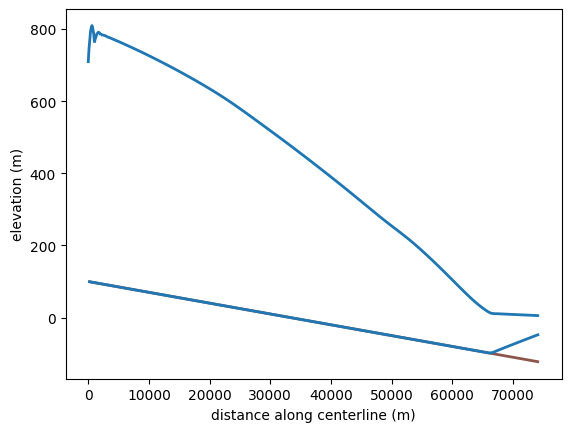

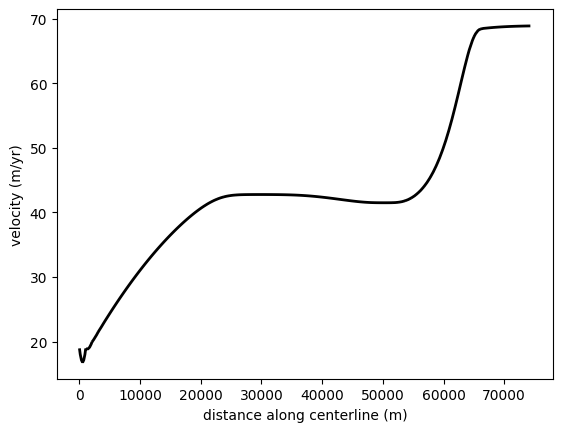

In [41]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

# Plot the previous timestep profile
# firedrake.plot(icepack.depth_average(prev_b), edgecolor="tab:green", axes=axes)
# prev_zb = firedrake.interpolate(prev_s-prev_h, prev_Q)
# firedrake.plot(icepack.depth_average(prev_zb), edgecolor="tab:green", axes = axes)
# firedrake.plot(icepack.depth_average(prev_s), edgecolor="tab:green", axes = axes);

# Plot the current timestep profile)
firedrake.plot(icepack.depth_average(model_b), edgecolor="tab:brown", axes=axes)
zb = firedrake.interpolate(model_s-model_h, model_Q)
firedrake.plot(icepack.depth_average(zb), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(model_s), edgecolor="tab:blue", axes = axes);

fig2, axes2 = plt.subplots()
axes2.set_xlabel("distance along centerline (m)")
axes2.set_ylabel("velocity (m/yr)")
firedrake.plot(icepack.depth_average(prev_u), axes=axes2);

# print(prev_h.dat.data)
# print(mid_h_1.dat.data)
# print(mid_h_2.dat.data)
# print(model_h.dat.data)

# print(prev_u.dat.data)
# print(model_u.dat.data)

[109710.54873998 109422.5921662  109136.41557514 108852.15213698
 108569.92759671 108289.66902059 108011.39014244 107735.20308816
 107461.21710798 107189.54040719 106919.94013755 106652.2844246
 106386.6722839  106123.20069503 105861.96619537 105602.7809787
 105345.73523386 105090.92084758 104838.43161058 104587.81414521
 104339.14335242 104092.50230427 103847.97440452 103605.42178547
 103364.87078627 103126.40095417 102890.09381654 102655.57267785
 102422.83444191 102191.9505671  101962.9927347  101735.90319678
 101510.61810026 101287.20541167 101065.73436708 100846.14364905
 100628.12135705 100411.72910898 100197.02804857  99984.07967122
  99772.80630571  99562.97011054  99354.71626922  99148.03073896
  98942.8990126   98739.30722594  98537.24061503  98336.68514546
  98137.62623133             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan           

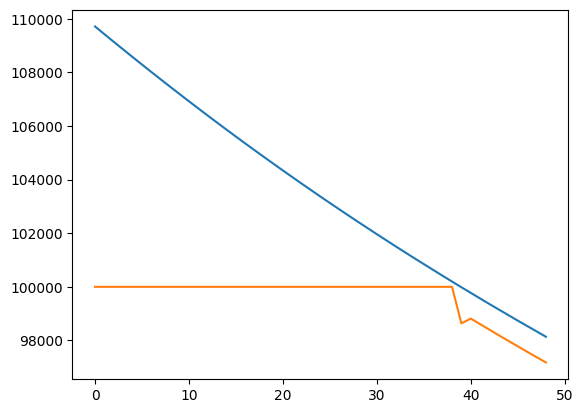

In [22]:
plt.plot(Lx_list_1)
plt.plot(Lx_list_2)

print(Lx_list_1)
print(Lx_list_2)
print(h_min_list)
print(u_min_list)

### Old Functions

In [25]:
def find_endpoint_1(src_lx, src_nx, src_h, h_min):
    for i in range(0, len(src_h.dat.data)):
        if src_h.dat.data[i] <= h_min:
            return src_lx*i/len(src_h.dat.data)
    return src_lx

In [ ]:
import tqdm

num_years = 100
timesteps_per_year = 2

dt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a = firedrake.interpolate(1.7 - 4.7 * x / Lx, Q) # Ramping accumulation along length
h = h0.copy(deepcopy = True)
u = u0.copy(deepcopy = True)

height_min1 = np.zeros(num_timesteps) * np.nan
height_min2 = np.zeros(num_timesteps) * np.nan
endpoints = np.zeros(num_timesteps) * np.nan

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness = h,
        velocity = u,
        accumulation = a,
        thickness_inflow = h0,
    )
    
    height_min1[step] = h.dat.data_ro.min()

    h = icepack.interpolate(conditional(lt(h,h_calving),h_min,h),Q) # Calving to minimum stable value (use UFL for functions)

    # Remeshing Steps:
        # Find new endpoint
    endpoint = find_endpoint(Lx, nx, h, h_min)
        # Shrink model
    # Q_s, V_s, h1_s, u1_s, a_s, h0_s, b_s, s1_s, C_s = shrink_model(nx, Lx, endpoint, h1, u1, a, h0, b, s1, C)
        # Recalculate surface
        # Initialize new solver
        # Re-assign functions, length, solver

    s = icepack.compute_surface(thickness=h, bed=b)

    u = solver.diagnostic_solve(
        velocity = u,
        thickness = h,
        surface = s,
        fluidity = A,
        friction = C,
    )

    endpoints[step] = endpoint
    height_min2[step] = h.dat.data_ro.min()

### Function Tests

In [ ]:
# Test shrink functions

# Initialze some smaller test meshes
mesh1d_test = firedrake.IntervalMesh(nx, 90000)
mesh_test = firedrake.ExtrudedMesh(mesh1d_test, layers=1)
Q_test = firedrake.FunctionSpace(mesh_test, "CG", 2, vfamily="R", vdegree=0)
V_test = firedrake.FunctionSpace(mesh_test, "CG", 2, vfamily="GL", vdegree=0)

# Shrink the meshes
h0_test = shrink_function(h0, nx, Lx, 90000, Q_test)
u0_test = shrink_function(u0, nx, Lx, 90000, V_test)
s0_test = shrink_function(s0, nx, Lx, 90000, Q_test)

# Chart output
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("speed (m / yr)")

u0_test_scaled = firedrake.interpolate(u0_test/5,V_test);
firedrake.plot(icepack.depth_average(u0_test_scaled), axes=axes);
firedrake.plot(icepack.depth_average(s0_test), axes=axes);

zb0_test = firedrake.interpolate(s0_test-h0_test, Q_test)
firedrake.plot(icepack.depth_average(zb0_test), axes=axes);

In [ ]:
# Model Remesh Test
dt = 0.25

# Set accumulation rate and copy initial height and velocities
a = firedrake.interpolate(1.7 - 4.7 * x / Lx, Q)
h1 = h0.copy(deepcopy = True)
u1 = u0.copy(deepcopy = True)

# Solve the first two timesteps WITHOUT remeshing
h1 = solver.prognostic_solve(dt, thickness=h1, velocity=u1, accumulation=a, thickness_inflow=h0)
s1 = icepack.compute_surface(thickness=h1, bed=b)
u1 = solver.diagnostic_solve(velocity=u1, thickness=h1, surface=s1, fluidity=A, friction=C)

h2 = solver.prognostic_solve(dt, thickness=h1, velocity=u1, accumulation=a, thickness_inflow=h0)
s2 = icepack.compute_surface(thickness=h2, bed=b)
u2 = solver.diagnostic_solve(velocity=u1, thickness=h2, surface=s2, fluidity=A, friction=C)

# Remesh (using the same initial length, so really just copying all the functions to a new mesh)
Q_s, V_s, h1_s, u1_s, a_s, h0_s, b_s, s1_s, C_s = shrink_model(nx, Lx, 100000, h1, u1, a, h0, b, s1, C)

# Initialize a new model and solver (is this necessary with every remesh?)
# model2 = icepack.models.HybridModel(friction = schoof_approx_friction)
model2 = icepack.models.HybridModel(friction = weertman_friction)
solver2 = icepack.solvers.FlowSolver(model2, **opts)

# Solve the second timestep with the remeshed functions
h2_s = solver2.prognostic_solve(dt, thickness=h1_s, velocity=u1_s, accumulation=a_s, thickness_inflow=h0_s)
s2_s = icepack.compute_surface(thickness = h2_s, bed = b_s)
u2_s = solver2.diagnostic_solve(velocity=u1_s, thickness=h2_s, surface=s2_s, fluidity=A, friction=C_s) # THIS LINE IS THE ISSUE

# Plot profile.
# Black = initial conditions, first timestep
# Blue = second timestep without shortening
# Green = second timestep with shortening
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("height (m)")

zb0 = firedrake.interpolate(s0-h0, Q)
zb1 = firedrake.interpolate(s1-h1, Q)
zb2 = firedrake.interpolate(s2-h2, Q)
zb2_s = firedrake.interpolate(s2_s-h2_s, Q_s)

firedrake.plot(icepack.depth_average(b_s), axes = axes);
firedrake.plot(icepack.depth_average(zb0), axes = axes);
firedrake.plot(icepack.depth_average(zb1), axes=axes);
firedrake.plot(icepack.depth_average(zb2), edgecolor = "tab:blue", axes=axes);
firedrake.plot(icepack.depth_average(zb2_s), edgecolor = "tab:green", axes=axes);
firedrake.plot(icepack.depth_average(s0), axes = axes);
firedrake.plot(icepack.depth_average(s1), axes=axes);
firedrake.plot(icepack.depth_average(s2), edgecolor = "tab:blue", axes=axes);
firedrake.plot(icepack.depth_average(s2_s), edgecolor = "tab:green", axes=axes);

# Plot Velocity.
# Black = initial conditions, first timestep
# Blue = first step (before shortening)
fig2, axes2 = plt.subplots()
axes2.set_xlabel("distance (m)")
axes2.set_ylabel("velocity (m/yr)")
firedrake.plot(icepack.depth_average(u0), axes=axes2);
firedrake.plot(icepack.depth_average(u1), edgecolor = "tab:blue", axes=axes2);
firedrake.plot(icepack.depth_average(u1_s), edgecolor = "tab:green", axes=axes2);
firedrake.plot(icepack.depth_average(u2), edgecolor = "tab:blue", axes=axes2);
firedrake.plot(icepack.depth_average(u2_s), edgecolor = "tab:green", axes=axes2);

# firedrake.plot(icepack.depth_average(u1_s/10), axes=axes);

In [45]:
# Endpoint tests
test_val_x1 = find_endpoint_1(Lx, nx, b, 50)
test_val_x2 = find_endpoint_2(Lx, nx, b, 50)
test_val_x3 = find_endpoint(Lx, nx, b, 50)
print(test_val_x1)
print(test_val_x2)
print(test_val_x3)

test_val_y1 = b.at(test_val_x1,0)
test_val_y2 = b.at(test_val_x2,0)
test_val_y3 = b.at(test_val_x3,0)
print(test_val_y1)
print(test_val_y2)
print(test_val_y3)

test_val_x_haf = find_endpoint_haf(Lx, nx, h0, s0, Q)
print(test_val_x_haf)

16551.724137931036
15862.068965517243
16666.666666666664
50.34482758620689
52.41379310344826
50.00000000000001
88435.03279666073
